In [1]:
import pyspark
from pyspark import SparkContext
import json
import numpy as np
from xgboost import XGBRegressor
import sys
import time
import pickle
from tqdm import tqdm
from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data
from better_features import extract_review_data
from better_features import extract_business_data
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

import pyspark
from pyspark import SparkContext
# sc = pyspark.SparkContext()

In [2]:
eval_path = '../yelp_true.csv'
df_merged = pd.read_csv('xgb_log_optimize.csv')
df_eval = pd.read_csv(eval_path)

In [9]:
# Prediction RMSE
df_merged = pd.merge(df_merged, df_eval, on=["user_id", "business_id"])
eval_rmse = sqrt(mean_squared_error(df_merged['stars'], df_merged['prediction']))
print("xgb Test RMSE:", eval_rmse)

xgb Test RMSE: 0.9784431064627526


In [10]:
df_merged

In [19]:
# 绘图函数,实际评分（1到5星）被预测为其他评分
def plot_distribution(df, actual_star, title):
    df_star = df[df['stars'] == actual_star]

    # 对预测结果进行分档，使用自定义的分割点
    bins = [0, 1.5, 2.5, 3.5, 4.5, 5.5]
    labels = ['1-Star', '2-Star', '3-Star', '4-Star', '5-Star']
    df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)

    # 计算每个预测类别的数量
    distribution = df_star['predicted_category'].value_counts().reindex(labels, fill_value=0)
    print(f"{actual_star}-star prediction, \nerror distribution: {distribution}")

    # 绘制柱状图
    plt.figure(figsize=(5, 3))
    distribution.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Predicted Star Rating')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=0)
    plt.show()

## 整体误差分布解读 (数据分布不平均， 想办法采样或者别的办法)
#### 1.0星评价
- 平均误差：2.13，表明模型倾向于将实际为1星的评价预测得过高。
- 标准偏差：0.70，误差分布相对集中，但仍有不小的变异性。
- 最小/最大误差：从-0.38到4.15，极端值表明有些预测与实际相差甚远。
#### 2.0星评价
- 平均误差：1.37，同样显示出过高预测的倾向。
- 标准偏差：0.53，相对集中的误差分布。
- 最小/最大误差：从-1.43到3.03，极端误差较1星时略低。
#### 3.0星评价
- 平均误差：0.55，预测相对更加准确，但仍稍偏高。
- 标准偏差：0.47，误差分布较为集中。
- 最小/最大误差：从-1.76到1.99，误差范围逐步缩小。
#### 4.0星评价
平均误差：-0.22，平均预测略低于实际评分，这是一个改变的标志。
标准偏差：0.44，较集中的误差分布。
最小/最大误差：从-3.02到1.18，显示出预测偶尔会显著低于实际。
#### 5.0星评价
平均误差：-0.92，显著地低于实际评分，表明模型在高评分的预测上最不准确。
标准偏差：0.47，误差分布相对一致。
最小/最大误差：从-4.33到0.28，有最大的误差下限，表明在某些情况下预测远远低于实际。

In [7]:
df_merged['error'] = df_merged['prediction'] - df_merged['stars']
error_distribution = df_merged.groupby('stars')['error'].describe()

In [8]:
# 根据实际星级分组的误差
print(error_distribution)

         count      mean       std       min       25%       50%       75%  \
stars                                                                        
1.0     7818.0  2.131701  0.700590 -0.381129  1.703234  2.184711  2.620542   
2.0    12812.0  1.365074  0.532484 -1.428368  1.022734  1.389820  1.738596   
3.0    30492.0  0.546423  0.468455 -1.759285  0.239334  0.555065  0.878927   
4.0    53711.0 -0.220427  0.442325 -3.019639 -0.500150 -0.187081  0.092988   
5.0    42163.0 -0.921321  0.465962 -4.331694 -1.190064 -0.871922 -0.597662   

            max  
stars            
1.0    4.151030  
2.0    3.030330  
3.0    1.995808  
4.0    1.181397  
5.0    0.281387  


In [132]:
## 有小于1的评分，可以修正

star, 1, distribution: predicted_category
1-Star     149
2-Star    1242
3-Star    3953
4-Star    2383
5-Star      91
Name: count, dtype: int64


/tmp/ipykernel_16489/3734750885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


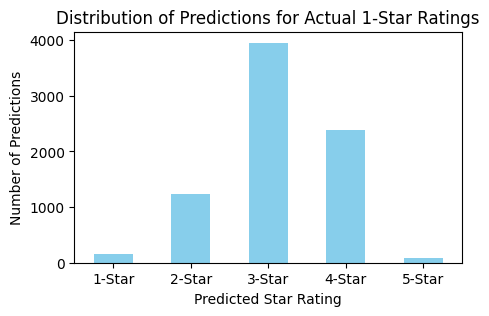

star, 2, distribution: predicted_category
1-Star      22
2-Star     736
3-Star    6700
4-Star    5260
5-Star      94
Name: count, dtype: int64


/tmp/ipykernel_16489/3734750885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


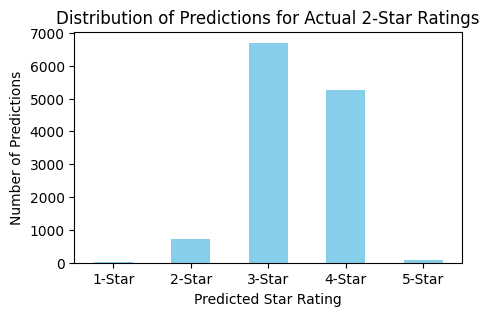

/tmp/ipykernel_16489/3734750885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


star, 3, distribution: predicted_category
1-Star       10
2-Star      517
3-Star    13181
4-Star    16449
5-Star      335
Name: count, dtype: int64


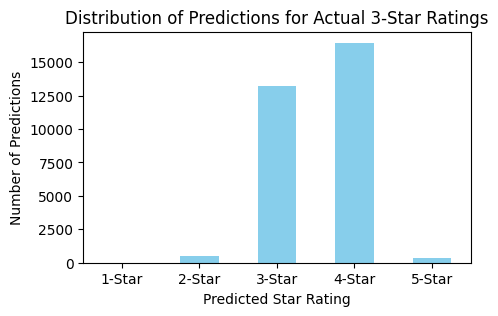

star, 4, distribution: predicted_category
1-Star        3
2-Star      337
3-Star    13098
4-Star    38453
5-Star     1820
Name: count, dtype: int64


/tmp/ipykernel_16489/3734750885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


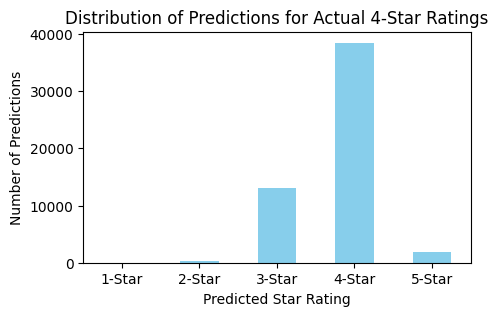

star, 5, distribution: predicted_category
1-Star        6
2-Star      177
3-Star     4323
4-Star    30346
5-Star     7311
Name: count, dtype: int64


/tmp/ipykernel_16489/3734750885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_star['predicted_category'] = pd.cut(df_star['prediction'], bins=bins, labels=labels, right=False)


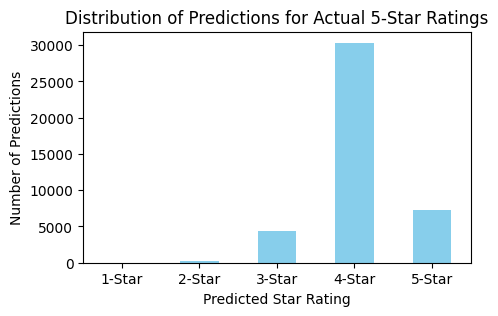

In [44]:
# 为实际1-5星评价绘制分布图
for star in range(1, 6):
    plot_title = f'Distribution of Predictions for Actual {star}-Star Ratings'
    plot_distribution(df_merged, star, plot_title)

## 我们可以分析每个实际评分（1到5星）被预测为其他评分的情况。

#### 实际评分为1星的情况：
大部分误分类集中在3星和4星的预测，说明模型对于这部分差评有着过高的估计。
很少的误分类为5星，显示模型对极端差评的预测较为准确。
误分类总数占实际1星评价的比例较小（149+1242+3953+2383+91=7818），这说明模型在1星评价的预测上整体表现较好。
#### 实际评分为2星的情况：
误分类同样集中在3星和4星，与1星的情况类似，模型倾向于将差评预测得过高。
2星的预测误分类数量相对于实际2星评价总数（22+736+6700+5260+94=12812）占比较高，显示模型在2星评价的预测上可能存在明显的问题。
#### 实际评分为3星的情况：
大部分误分类为4星，这可能是因为3星评价本身是一个中立的评价，模型容易倾向于正面或负面的极端。
3星评价的误分类数目与实际3星评价的总数相比（10+517+13181+16449+335=30492），占比较高，说明模型在中立评价的判断上不是很准确。
#### 实际评分为4星的情况：
误分类主要在3星和5星，其中4星误分类为5星的情况最多，可能是因为4星评价与5星评价在特征上的相似度较高。
实际4星评价的误分类数目较大（3+337+13098+38453+1820=53711），显示模型在辨别高好评与最高好评之间有难度。
#### 实际评分为5星的情况：
绝大多数误分类集中在4星，这再次说明模型在高星评价（特别是5星）的预测上存在困难。
实际5星评价的误分类数目也非常高（6+177+4323+30346+7311=42163），表明模型对5星评价的预测准确度有待提高。
#### 总结与进一步思考
模型在预测最高（5星）和最低（1星）评价时，相对准确度较高。
中等评价（尤其是3星和4星）的预测准确度较低，可能需要优化模型或调整特征以提高区分能力。
从误分类的分布来看，模型倾向于将差评预测为中评，将好评预测为最高评价。

### 改进方案：
把(3,4) ===> (1,2)

(3) ===> (4,5)

### 对整体四舍五入前后误差分布对比
#### 1.0星评价
平均误差：几乎相同（2.131108 vs 2.131701），表明四舍五入对平均误差的影响非常小。
标准偏差：略有增加（0.754553 vs 0.700590），显示四舍五入后误差的分散程度略有上升。
误差范围：从0到4，与之前的范围(-0.38到4.15)相比，变得更加“整齐”且无负值。
#### 2.0星评价
平均误差：几乎相同（1.364346 vs 1.365074）。
标准偏差：同样略增（0.609505 vs 0.532484），分散程度略高。
误差范围：从-1到3，变化不大但整体更集中。
#### 3.0星评价
平均误差：几乎相同（0.543815 vs 0.546423）。
标准偏差：四舍五入后略增（0.553120 vs 0.468455）。
误差范围：从-2到2，简化了分布。
#### 4.0星评价
平均误差：几乎相同（-0.222692 vs -0.220427）。
标准偏差：略增（0.503745 vs 0.442325）。
误差范围：从-3到1，范围简化且集中。
#### 5.0星评价
平均误差：略增（-0.937955 vs -0.921321）。
标准偏差：略增（0.538664 vs 0.465962）。
误差范围：从-4到0，误差范围更集中且简化。

**说明不是数据不接近的问题，而是的的确确预测错了**

### First-try: analyze integer ratings 对整体四舍五入查看RMSE（变差）


In [63]:
df = df_merged

In [55]:
def custom_round_up(x):
    import math
    return math.ceil(x) if x - int(x) == 0.5 else round(x)

In [56]:
df['rounded_prediction'] = df['prediction'].apply(custom_round)

In [57]:
# df['rounded_prediction'] = df['prediction'].round().astype(int)

In [58]:
df['rounded_error'] = df['rounded_prediction'] - df['stars']
rounded_error_distribution = df.groupby('stars')['rounded_error'].describe()
rounded_error_distribution

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1.0,7818.0,2.131108,0.754553,0.0,2.0,2.0,3.0,4.0
2.0,12812.0,1.364346,0.609505,-1.0,1.0,1.0,2.0,3.0
3.0,30492.0,0.543815,0.553120,-2.0,0.0,1.0,1.0,2.0
4.0,53711.0,-0.222692,0.503745,-3.0,-1.0,0.0,0.0,1.0
5.0,42163.0,-0.937955,0.538664,-4.0,-1.0,-1.0,-1.0,0.0


In [59]:
original_group_counts = df['prediction'].apply(lambda x: int(x)).value_counts()
rounded_group_counts = df['rounded_prediction'].apply(lambda x: int(x)).value_counts()

In [32]:
original_group_counts

prediction
3    83220
4    50300
2    12505
1      838
5      112
0       21
Name: count, dtype: int64

In [33]:
rounded_group_counts

rounded_prediction
4    92891
3    41255
5     9651
2     3009
1      190
Name: count, dtype: int64

In [60]:
test_rmse = sqrt(mean_squared_error(df['stars'], df['rounded_prediction']))
print("xgb Test ROUNDED RMSE:", test_rmse)

xgb Test ROUNDED RMSE: 1.018653074321903


### 5-star星级的错误分布和修正(map成整数)

In [14]:
df = df_merged

In [129]:
## SLIGHT FIX???
# 0.9784431064627526 ORIGINAL RMSE
# 0.9784331180092208
# 0.9784324561949815
# 0.9784322072848275 >= 4.99
# 0.9784321523039587 > 5

df['adjusted_prediction'] = df['prediction'].apply(lambda x: 5 if x > 5 else x)

test_rmse = sqrt(mean_squared_error(df['stars'], df['adjusted_prediction']))
print("xgb Test ROUNDED to five star RMSE:", test_rmse)

xgb Test ROUNDED to five star RMSE: 0.9784321523039587


In [52]:
adjusted_errors_5_to_other['adjusted_prediction'].value_counts()

adjusted_prediction
5.000000    11
3.240498     3
3.898246     3
3.459333     3
3.928777     3
            ..
4.843401     1
4.149785     1
4.046299     1
3.782876     1
3.445857     1
Name: count, Length: 103803, dtype: int64

star, 5, distribution: predicted_category
1-Star        6
2-Star      177
3-Star     4323
4-Star    30346
5-Star     7180
Name: count, dtype: int64


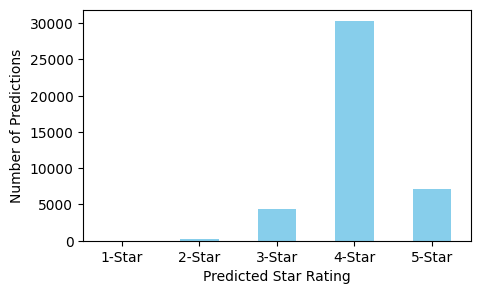

In [67]:
# 筛选出实际评分为4星的数据行
adjusted_errors_5_to_other = df[(df['stars'] == 4) & (df['adjusted_prediction'] == 5)]
plot_distribution(adjusted_errors_5_to_other, 4, "")

star, 5, distribution: predicted_category
1-Star        6
2-Star      177
3-Star     4323
4-Star    30346
5-Star     7180
Name: count, dtype: int64


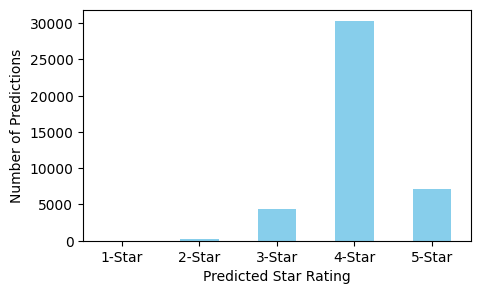

In [68]:
# 筛选出实际评分为5星的数据行，但预测错了的(减小了131行)
adjusted_errors_5_to_other = df[(df['stars'] == 5) & (df['adjusted_prediction'] != 5)]
plot_distribution(adjusted_errors_5_to_other, 5, "")

# 1/2-star星级的错误分布(map成整数) df=df_merged, # 筛选出真实评分为1或2星，错误的预测评分为3星以上的数据

1-star prediction, 
error distribution: predicted_category
1-Star     149
2-Star    1242
3-Star    3953
4-Star    2383
5-Star      91
Name: count, dtype: int64


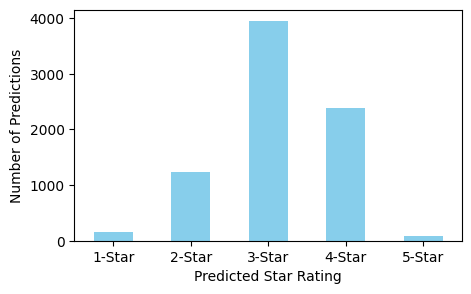

In [20]:
# # 筛选出实际评分为1星的数据行
# df = df_merged
# adjusted_errors_1_to_other = df[(df['stars'] == 1)]
# plot_distribution(adjusted_errors_1_to_other, 1, "")

In [21]:
# 筛选出真实评分为1或2星，预测评分为3星以上的数据
df = df_merged
misclassified = df[(df['stars'].isin([1, 2])) & (df['prediction'].round() >= 3)] # 至少>=2.50

In [22]:
misclassified

,user_id,business_id,prediction,stars
21,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0
26,RNUV7k_Ng4KdasXQMsOo6w,74Q5s1J1xknMX7TAkIPf8w,3.436701,2.0
41,EC5TGpxONfz4IZIjML0DpQ,q9kVbGaUwsalkhyFJdNQ0Q,2.860357,2.0
46,DuzZ68TZWlQ3mALJZ0ASVQ,TrOgTZ0DfmQxvpTehiNibQ,3.250278,2.0
51,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0
...,...,...,...,...
146976,FpqMgETBdQZC6DFclkrqLA,ZWcXoh_RO7rT2DdcyOzyfQ,3.759746,2.0
146978,5fqHDnZYDODFOitqFzf0Ag,aLcFhMe6DDJ430zelCpd2A,3.950187,1.0
146982,QNiMz3khnM7iAgr44DOXQw,6ZsiLiSWGK2pgw6t3LfzNQ,3.611674,2.0
146986,rCWrxuRC8_pfagpchtHp6A,da62X2tpj9tF0olWTigjBg,4.291145,2.0


In [23]:
with open('test_xgb_without_embedding', "rb") as model_file:
    xgb_model = pickle.load(model_file)

In [24]:
# 假设xgb_model是已经训练好的XGBoost模型
booster = xgb_model.get_booster()
feature_importance = booster.get_score(importance_type='weight')

# 将特征重要性转换为排序的列表
sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# 打印出最重要的特征和它们的分数
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: bus_review_count, Importance: 3815.0
Feature: avg_useful_score, Importance: 3796.0
Feature: average_stars, Importance: 3447.0
Feature: bus_stars, Importance: 2161.0
Feature: user_review_count, Importance: 2086.0
Feature: friends_count, Importance: 1436.0
Feature: city_encoded, Importance: 1400.0
Feature: useful, Importance: 925.0
Feature: funny, Importance: 886.0
Feature: fans, Importance: 865.0
Feature: yelping_since, Importance: 821.0
Feature: num_interactions, Importance: 745.0
Feature: compliments, Importance: 713.0
Feature: cool, Importance: 662.0
Feature: compliment_writer, Importance: 635.0
Feature: compliment_plain, Importance: 588.0
Feature: compliment_photos, Importance: 571.0
Feature: compliment_note, Importance: 548.0
Feature: compliment_cool, Importance: 527.0
Feature: elite_years, Importance: 518.0
Feature: compliment_hot, Importance: 469.0
Feature: compliment_more, Importance: 450.0
Feature: compliment_cute, Importance: 391.0
Feature: is_open, Importance: 322.0


In [25]:
# from better_features import FeatureProcessor, read_json_data, transform_user_data, transform_business_data
# from better_features import extract_review_data
# from better_features import extract_business_data

# def process_training_data(train_path):
#     try:
#         lines_train = sc.textFile(train_path)
#         train_data = lines_train.filter(lambda row: not row.startswith('user_id')).map(lambda line: line.split(',')).collect()
#         train_df = pd.DataFrame(train_data, columns=['user_id', 'business_id', 'stars'])
#         train_df['stars'] = train_df['stars'].astype(float)

#         processed_df = feature_processor.process_all_features(train_df)

#         X = processed_df.drop(['stars', 'user_id', 'business_id'], axis=1)
#         y = processed_df['stars']

#         return X, y
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None, None
        
# sc = pyspark.SparkContext()

# folder_path = '../data/'
# user_df = pd.read_csv('../well-trained/cache/user_df.csv')
# business_df = pd.read_csv('../well-trained/cache/business_df.csv')
# review_data = read_json_data(folder_path + '/review_train.json', extract_review_data, sc).collect()

# feature_processor = FeatureProcessor(user_df, business_df, review_data)
# X_val, y_val = process_training_data('../yelp_true.csv')
# combined_val_processed = pd.concat([X_val, df_merged['stars'], df_merged['prediction']], axis=1)

24/04/14 03:52:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 03:52:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
combined_val_processed = pd.read_csv('combined_val_processed.csv')

In [73]:
important_features = [feature for feature, importance in sorted_feature_importance[:20]]  # 取前10个最重要的特征
all_misclassified_high = combined_val_processed[important_features]
all_misclassified_high = (pd.concat([all_misclassified_high, df_merged['user_id'], df_merged['business_id']], axis=1))

eval_misclassification = pd.merge(all_misclassified_high, misclassified, on=['user_id', 'business_id'])
eval_misclassification['rounded_prediction'] = eval_misclassification['prediction'].round()

In [69]:
eval_misclassification

,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
0,15,23,2,0,0,0,1,0,0,0,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0,4.0
1,13,26,39,0,4,1,6,13,5,3,RNUV7k_Ng4KdasXQMsOo6w,74Q5s1J1xknMX7TAkIPf8w,3.436701,2.0,3.0
2,13,46,296,15,41,45,9,44,63,7,EC5TGpxONfz4IZIjML0DpQ,q9kVbGaUwsalkhyFJdNQ0Q,2.860357,2.0,3.0
3,13,74,134,15,20,19,1,25,20,7,DuzZ68TZWlQ3mALJZ0ASVQ,TrOgTZ0DfmQxvpTehiNibQ,3.250278,2.0,3.0
4,13,619,378,142,33,53,31,65,68,5,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18476,13,4,6,0,0,1,0,0,2,2,FpqMgETBdQZC6DFclkrqLA,ZWcXoh_RO7rT2DdcyOzyfQ,3.759746,2.0,4.0
18477,15,82,29,10,4,3,3,7,4,3,5fqHDnZYDODFOitqFzf0Ag,aLcFhMe6DDJ430zelCpd2A,3.950187,1.0,4.0
18478,10,46,3,6,1,1,0,0,0,0,QNiMz3khnM7iAgr44DOXQw,6ZsiLiSWGK2pgw6t3LfzNQ,3.611674,2.0,4.0
18479,15,11967,8551,2044,1151,2123,403,757,1408,1,rCWrxuRC8_pfagpchtHp6A,da62X2tpj9tF0olWTigjBg,4.291145,2.0,4.0


In [70]:
misclassified_high_descriptive = eval_misclassification.describe()
# misclassified_high_descriptive

In [11]:
# combined_val_processed[combined_val_processed['prediction'] > 5]

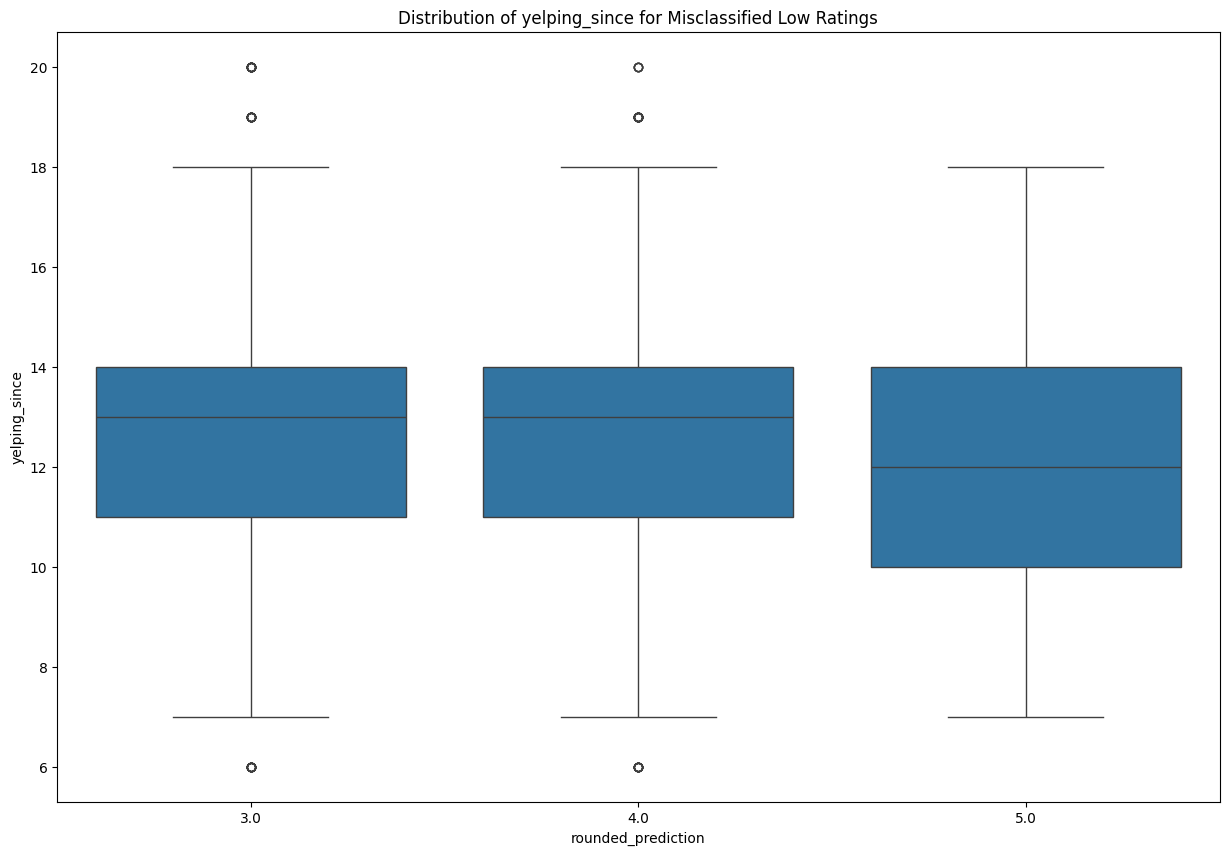

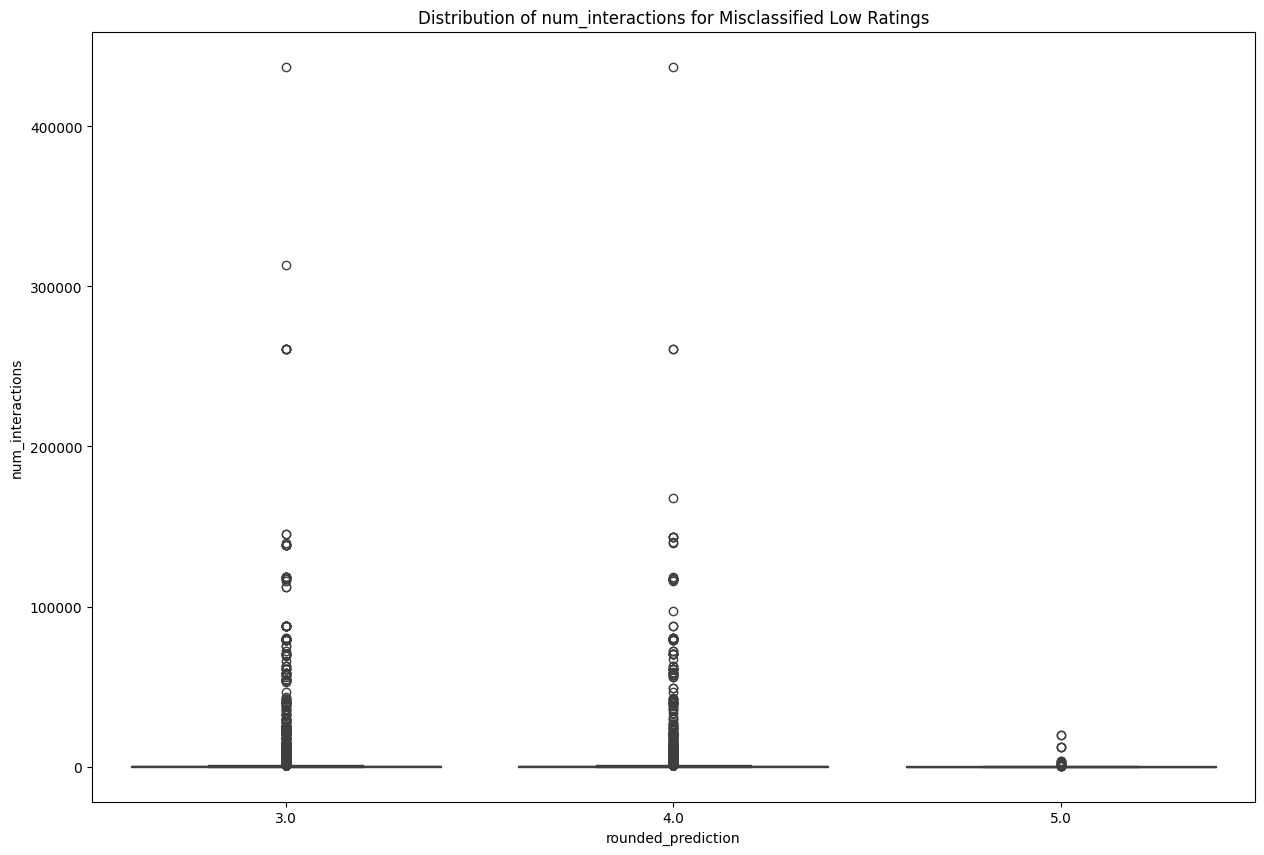

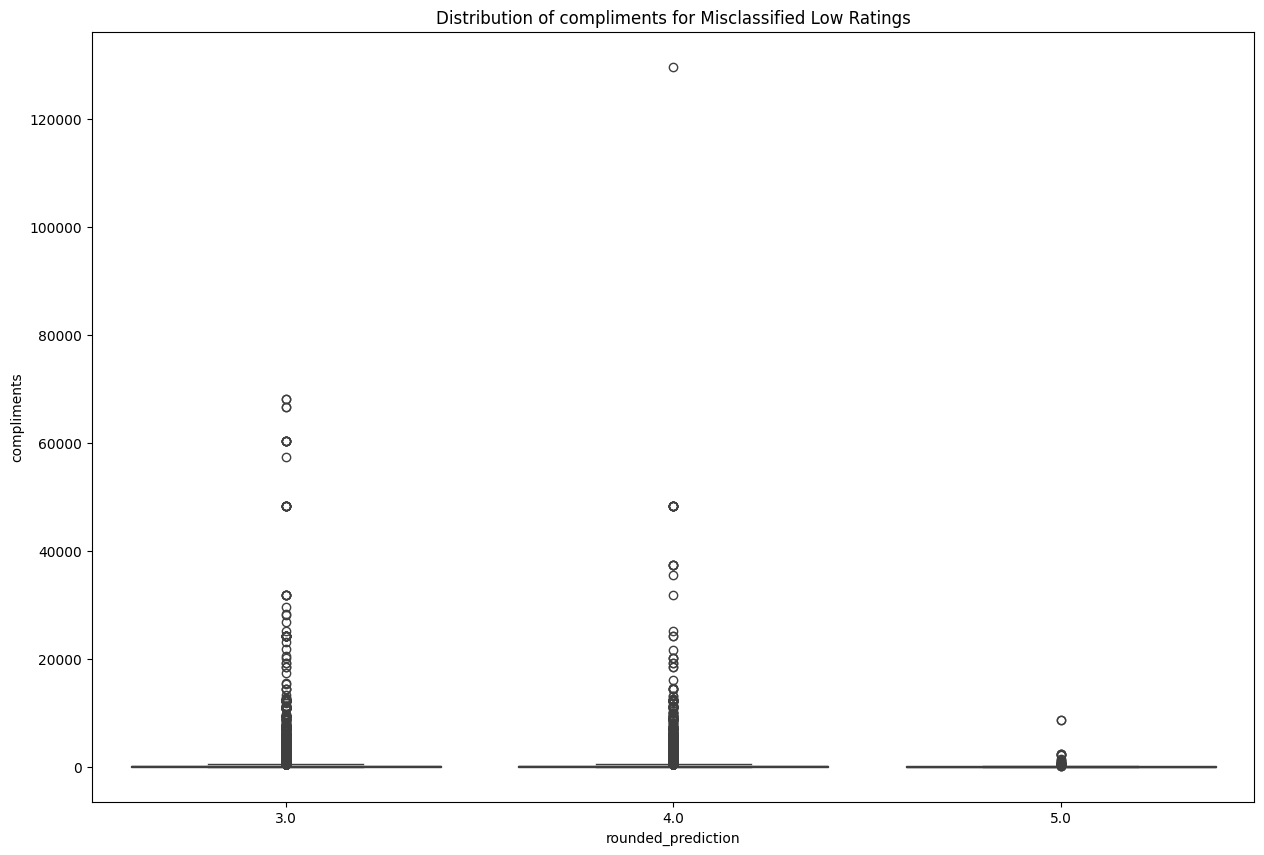

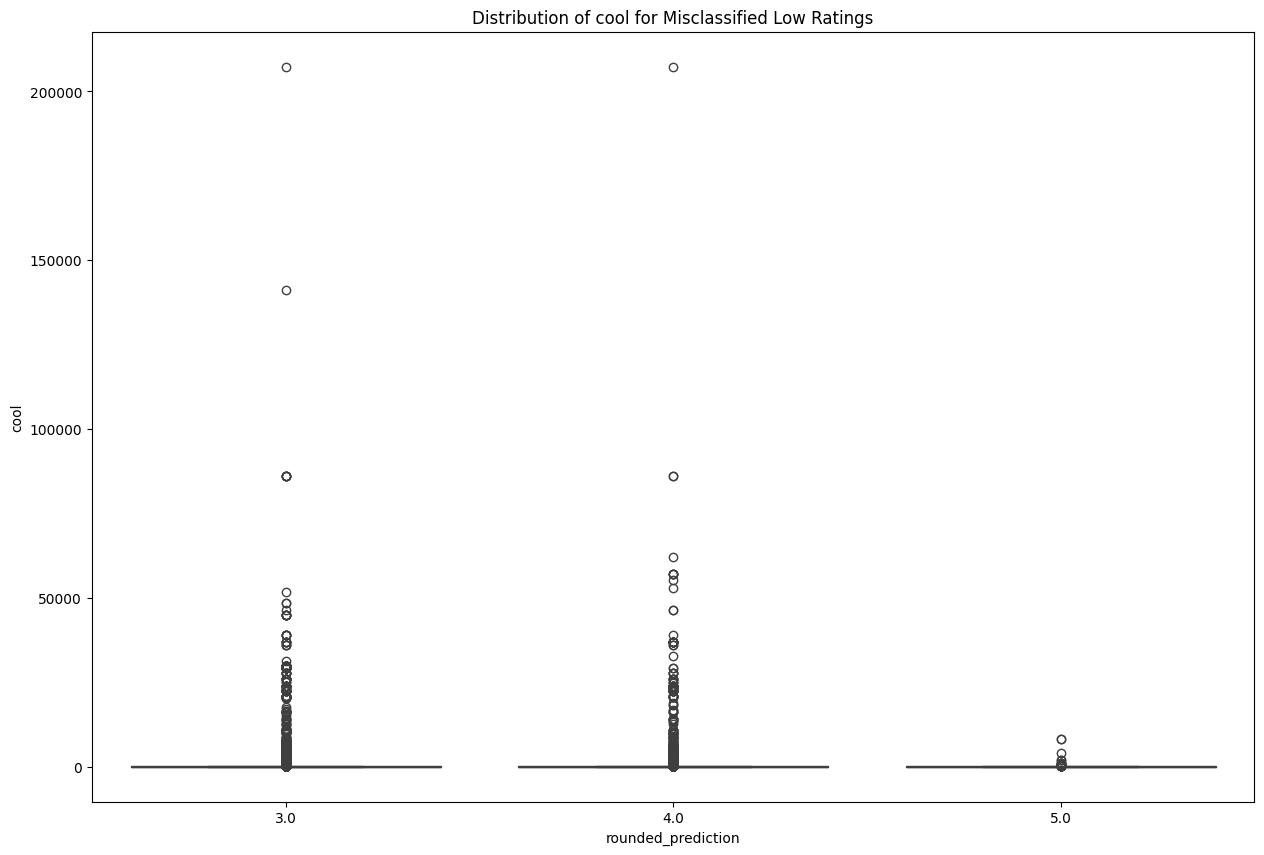

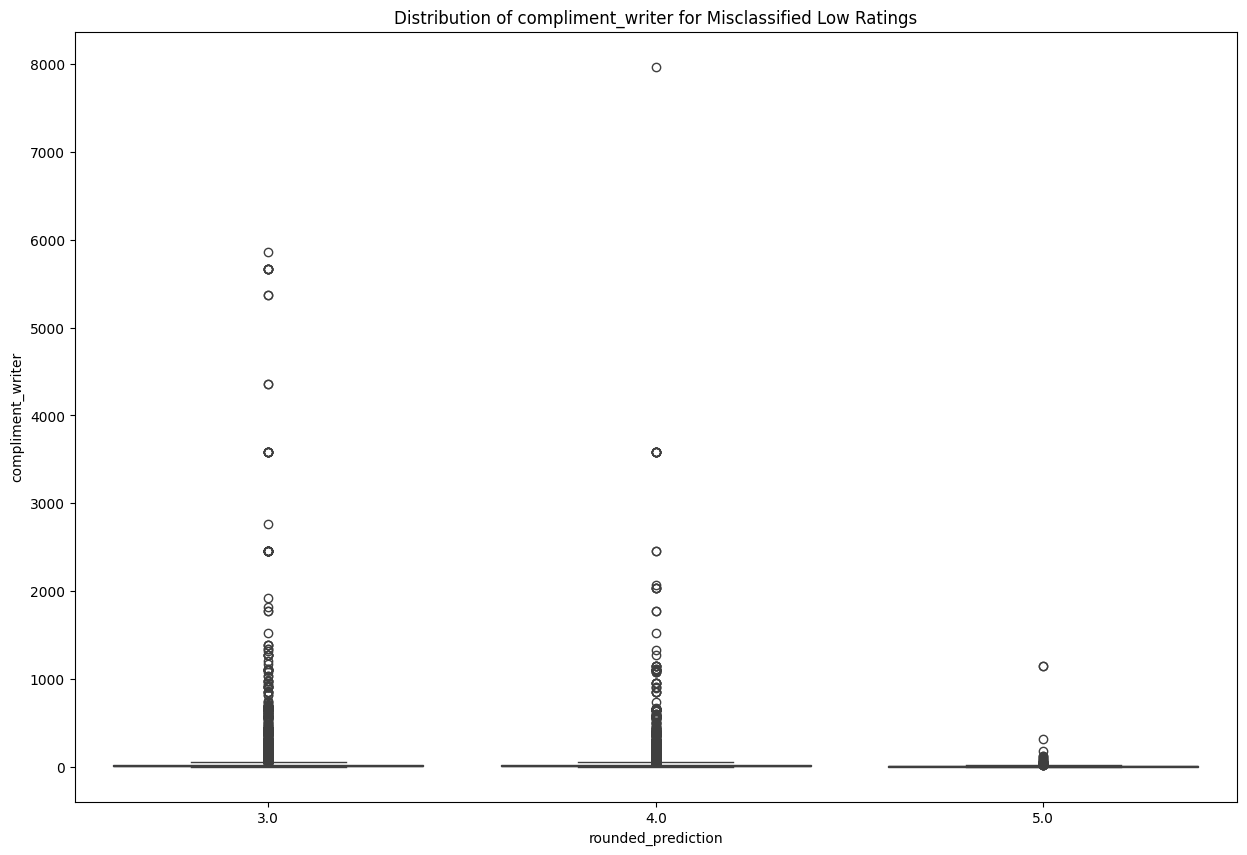

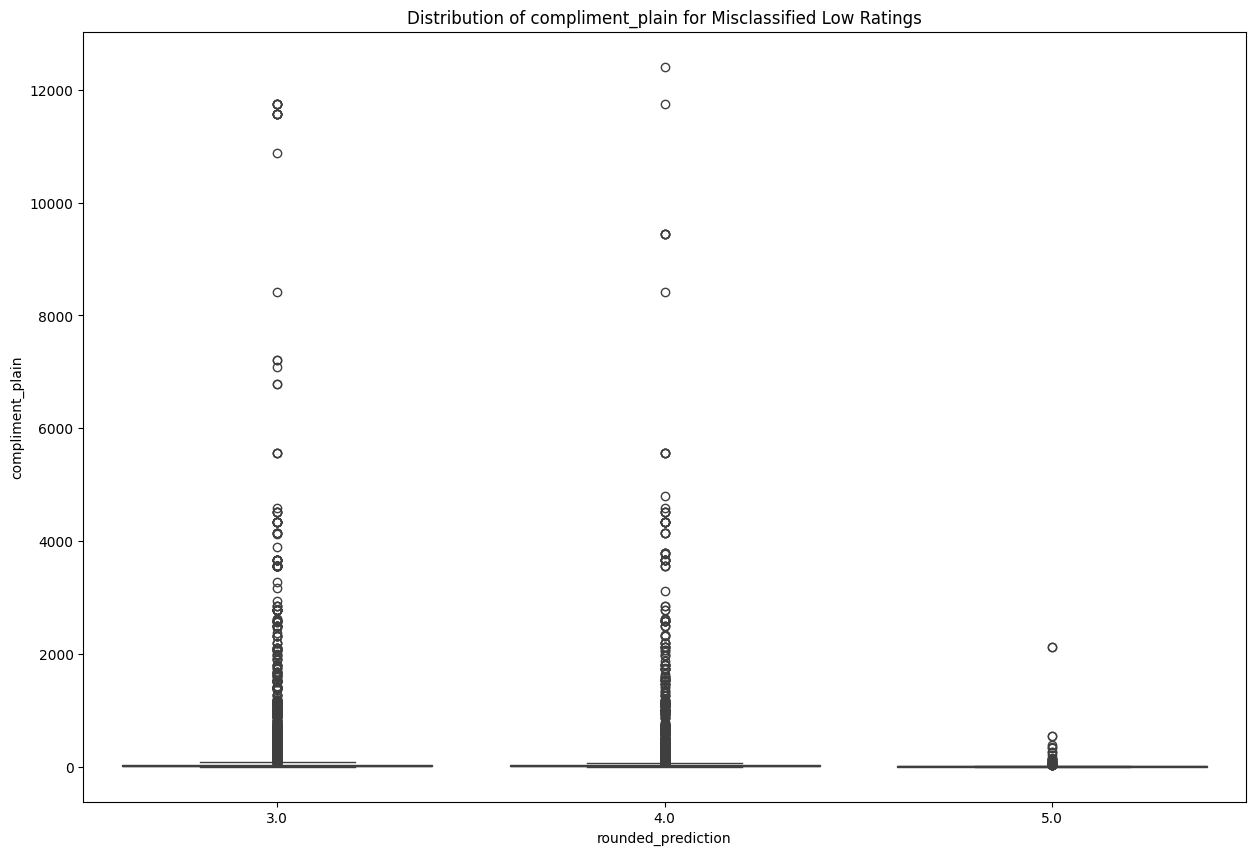

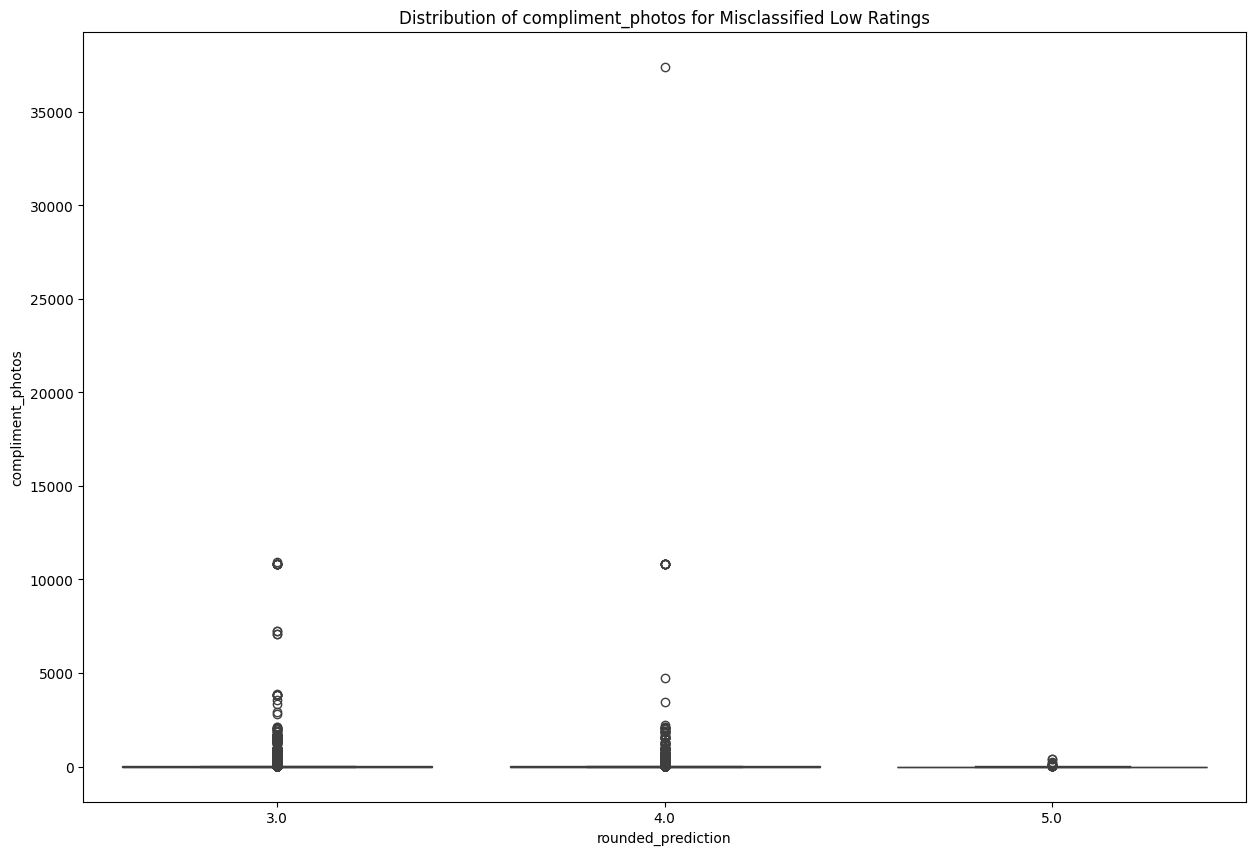

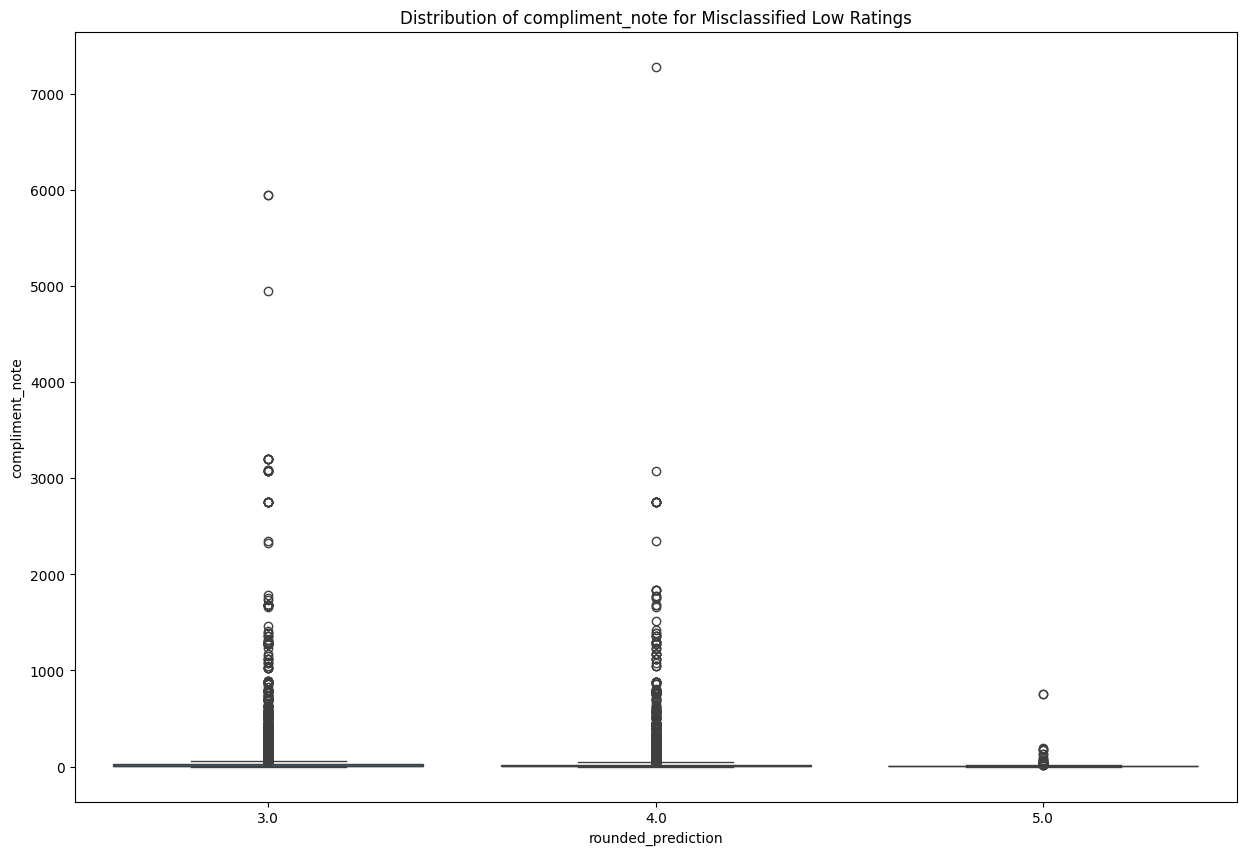

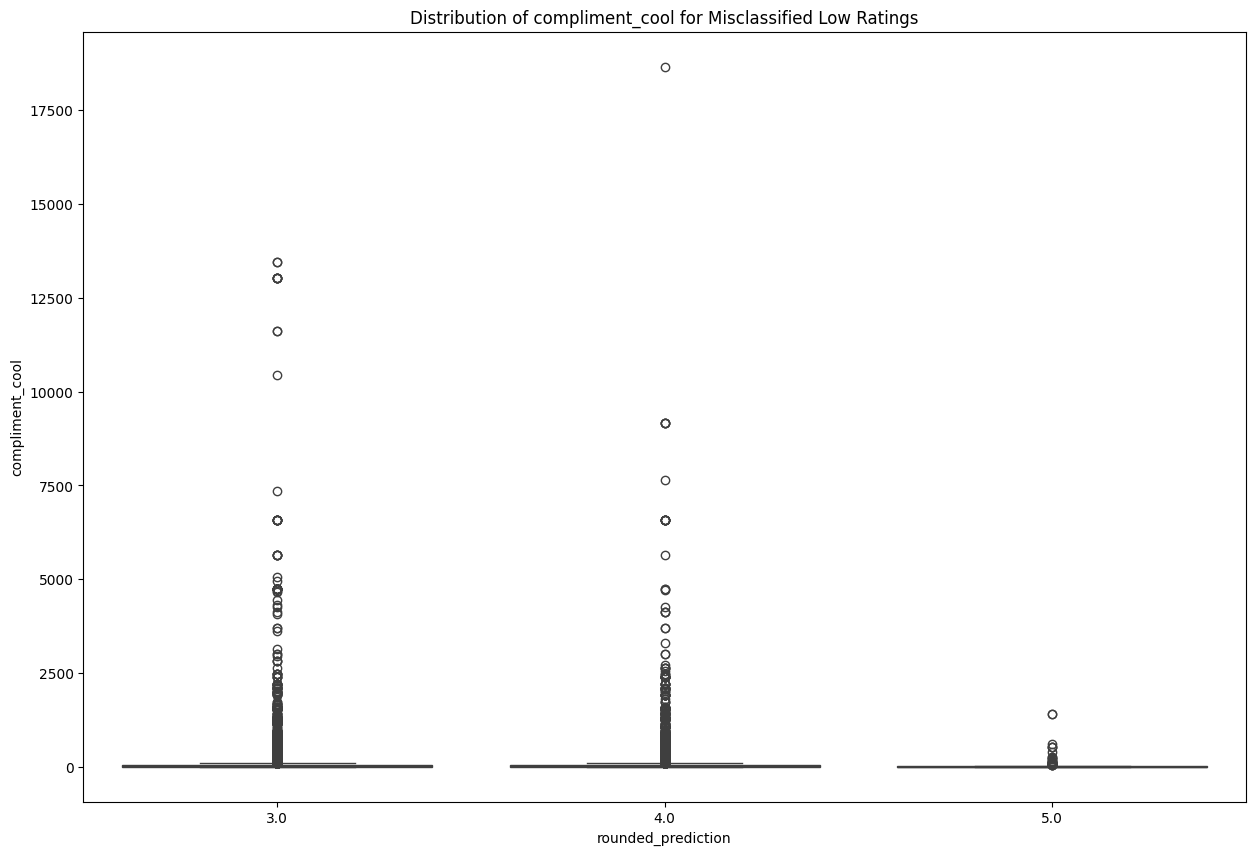

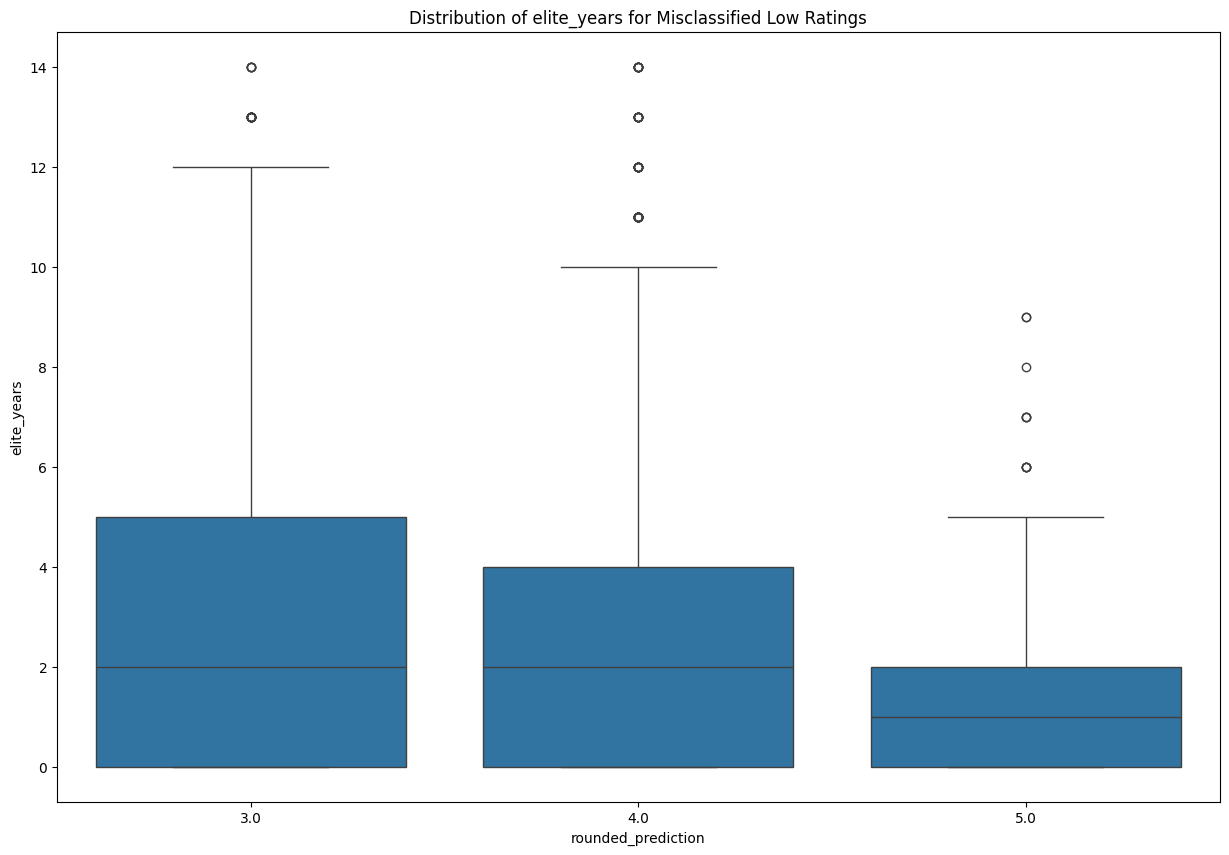

In [71]:
import seaborn as sns

# 对于每个重要特征，使用箱型图或小提琴图比较其分布
for feature in important_features:
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=eval_misclassification, x='rounded_prediction', y=feature)
    plt.title(f"Distribution of {feature} for Misclassified Low Ratings")
    plt.show()

- bus_review_count在不同的真实评分中变化不大
  
- **average_stars,**
这个箱型图展示了用户的平均评分（average_stars）在不同预测评级（rounded_prediction）下的分布情况。这里，我们关注的是将低评价（实际为1或2星）错误分类为3、4、5星的情况。
分析如下：
3星预测：
数据中心趋于接近3.5星，这意味着对于被预测为3星的用户，他们的平均评分实际上高于3星。可能有数据集的偏差，或者这些用户可能普遍对商家更宽容。
数据的分布范围（四分位数范围）相对较宽，尤其是下四分位数范围，延伸至2星以下，这可能意味着有一些用户尽管给出很低的评价，但他们的整体平均评分较高。
存在一些异常值，即那些低评分被显著高估的实例。
4星预测：
数据中心同样偏高，中位数接近4星，这暗示模型对那些平均评分高的用户的评价偏高。
分布的四分位数范围稍微集中，比3星的分布窄，表明被预测为4星的用户在平均评分上更加一致。
仍然存在异常值，这表明有少数用户的评价被极度高估。
5星预测：
分布中心也偏高，中位数在4星以上。这说明当模型将评价预测为5星时，这些用户通常的平均评分也很高。
分布四分位数范围相对于3星和4星的预测更为集中，这可能是因为在该数据集中，用户的平均评分真的很高。
异常值减少了，但仍然存在。这些数据点可能代表了模型在预测时的极端情况。
可能的原因分析：
数据不平衡：
如果数据集中高评分用户比例较高，那么模型可能会学习到偏向于预测更高的评分。
特征关联：
用户的平均评分average_stars可能与其他特征存在一定的关联，导致模型倾向于根据用户的一般慷慨度给出高预测。
为了提高模型的准确度，你可以考虑进行进一步的特征工程，尝试不同的模型超参数，或者探索更复杂的模型结构。此外，也可以进行更深入的数据质量评估，确保训练数据没有错误或偏差

- average_useful_stars
箱型图分析：
3星预测：
大部分数据聚集在相对低的avg_useful_score范围内，中位数接近于0，这意味着即使商家的评论在大多数情况下被认为不是很有用，这些评论也可能被模型预测为3星。
数据分布的范围较窄，表明对于这类预测错误的实例，avg_useful_score的变异度不大。
有一些离群点分布在高avg_useful_score值处，这可能表明少数的商家获得了一些特别高的有用评价。
4星预测：
这一类的中位数稍微高于3星预测，但仍然比较低。
分布范围相比3星预测略宽，表明在被错误预测为4星的实例中，avg_useful_score有更广的变化。
离群点数量增多，显示在4星预测中存在更多的实例，它们的avg_useful_score值异常高。
5星预测：
中位数进一步上升，但依然不高，表明即使是被预测为5星的商家，它们的评论也不一定普遍认为是有用的。
分布范围与4星预测相似，但离群点较少，这可能表明被预测为5星的错误分类实例中，高avg_useful_score值的情况相对较少。
可能的原因分析：
特征相关性：
avg_useful_score可能与其他一些未显示在图中的特征有关联，例如商家的总体评分或者评论的数量，而这些关联可能在模型训练中没有得到充分考虑。
用户行为：
用户可能倾向于对他们觉得好的商家更多地点击“有用”，这可能会导致预测评分偏高。
模型解释性：
需要进一步的模型解释工作，以确定模型是如何使用avg_useful_score这个特征的，并了解其在预测中的确切作用。
要改进模型预测，可以考虑以下几个方面：
数据处理：对离群点进行进一步分析，确定它们是否代表正常的用户行为或数据质量问题。
特征工程：可能需要对avg_useful_score进行归一化或变换，以减少异常值的影响。
模型调整：考虑使用正则化方法来减少对离群点的敏感度，或者尝试不同的模型结构来更好地捕获数据中的复杂关系。

- **bus_stars,**
对于被误分类的低评分（真实评分为1星或2星的数据），商家平均星级的中位数在3.5星左右，这表明即便是低分的评价，这些商家的整体平均星级也比较高。 如果一个商家的整体评级很高，模型可能就会忽略掉个别低分评价，依然给出较高的预测评分。
3星预测：
中位数约为3.0，说明对于被预测为3星的评论，这些商家的平均评分大体上符合预测。
分布的四分位距离较窄，表示大部分商家的平均星级较为集中在3星左右。
出现了几个低异常值，暗示一些实际评分较低的商家被预测为3星。
4星预测：
中位数略高于4星，说明在这些被误分类为4星的案例中，商家的平均星级通常也比较高。
四分位范围宽度适中，表明这类误分类的商家星级分布有一定的波动。
=存在一些低异常值。
5星预测：
中位数接近4.5星，表明那些被错误地预测为5星的商家，他们的平均星级通常很高。
分布的四分位距离相对于3星和4星预测略宽，这表明5星预测中商家星级的差异可能更大。
有少量的低异常值出现。
可能的原因分析：
预测偏差：
如果模型在某些情况下高估了低评价的商家，那么可能是由于模型过于重视bus_stars这个特征，尤其是当商家的总体评价较好时。
数据质量：
异常值的出现可能是由于一些数据质量问题，如评分不准确或个别用户评价行为的偏差。
商家评分的影响：
bus_stars特征的分布暗示，模型可能倾向于相信，平均而言，商家的整体评分是可靠的指标，即便面对一些低评价。
为了提升模型预测的准确性，可以采取以下措施：
调整特征权重：对模型中bus_stars的权重进行调整，避免模型过度依赖商家的平均星级。
考虑上下文信息：加入更多与用户-商家交互相关的特征，以提供对评分影响更全面的视角。
深入数据探索：深入分析异常值背后的数据，以理解这些商家为何能获得较高的平均评分，但在某些情况下得到了低评价。
通过这些措施，可以更准确地捕捉到那些导致误分类的复杂关系，并相应地调整模型。

- **city_encoded**
3星预测：
中位数较低，表示在被预测为3星的误分类中，大多数商家位于较低编号的城市。
四分位距离较大，说明这些误分类的商家分布在很宽的城市编码范围内。
有较多的低异常值，这可能指出一些特定的较低编号城市中商家的低评价被过高预测。
4星预测：
中位数更高，表明被误分类为4星的商家普遍位于编号更高的城市。
分布的四分位距离较窄，特别是下四分位数，意味着在较高编号的城市中，商家的评价倾向于被高估为4星。
出现了一些较高的异常值，指出在某些高编号城市，商家的评价有被显著高估的情况。
5星预测：
中位数和四分位距离均较4星预测时更低，表明误分类为5星的商家在编号更低的城市中较为常见。
分布中存在几个高异常值，这表明个别城市中的商家评价可能被高估。
可能的原因分析：
城市效应：
城市编码可能与其他一些不可观测的地理或经济特征相关，如城市规模、市场饱和度或消费者偏好。
模型学习的偏差：
如果city_encoded较高或较低的城市与其他积极或消极的特征一致性较高，则模型可能在不知不觉中学习到了这一关联，导致对这些地区商家的评价预测存在偏差。
数据不均衡：
某些编号的城市可能在数据集中代表性不足或过剩，导致模型在这些地区的预测表现不佳。
要提升模型预测的准确性，可以采取以下措施：
地理特征工程：深入研究city_encoded与目标变量之间的关系，可能需要更详细的地理信息来帮助模型更好地理解背景。
更复杂的模型：考虑使用可以捕获更复杂关系的模型，如随机森林或神经网络。
消除偏差：如果发现city_encoded导致不合理的预测偏差，可以尝试从特征集中移除它，或使用不同的编码策略。

- yelp_since & elite_years
elite_years 箱型图分析
中位数在3星和4星预测类别中相对较低，尤其在3星预测中更为显著，这可能表明精英用户更少被错误预测为低分。
5星预测中的四分位数范围最小，中位数也更低，这表明被错误预测为5星的用户中，精英年数通常不高。
类似地，存在一些高异常值，可能指出了个别精英用户的评分被高估。
结论和可能的原因
在yelping_since中的中等和稳定的中位数表明，用户在Yelp上的活跃时间对评分预测的影响可能不是很明显，或者模型没有充分利用这个特征来区分评分。
对于elite_years，较低的中位数和四分位数范围可能说明精英用户更少被高估评分，但这种趋势在预测5星时不明显

In [104]:
eval_misclassification[(eval_misclassification['average_stars'] >= 3) & (eval_misclassification['prediction'] >= 2)]

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
0,625,1.961538,4.42,4.0,42,32,416,21,2,1,15,23,2,0,0,0,1,0,0,0,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0,4.0
1,49,0.750000,3.97,3.0,168,43,462,21,5,5,13,26,39,0,4,1,6,13,5,3,RNUV7k_Ng4KdasXQMsOo6w,74Q5s1J1xknMX7TAkIPf8w,3.436701,2.0,3.0
2,42,0.928571,3.29,3.0,260,275,984,20,11,25,13,46,296,15,41,45,9,44,63,7,EC5TGpxONfz4IZIjML0DpQ,q9kVbGaUwsalkhyFJdNQ0Q,2.860357,2.0,3.0
3,203,2.521739,3.68,3.0,159,97,984,31,28,10,13,74,134,15,20,19,1,25,20,7,DuzZ68TZWlQ3mALJZ0ASVQ,TrOgTZ0DfmQxvpTehiNibQ,3.250278,2.0,3.0
4,39,1.777778,3.59,2.5,1085,493,416,267,210,68,13,619,378,142,33,53,31,65,68,5,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18476,358,1.448276,3.61,4.0,67,14,408,2,2,4,13,4,6,0,0,1,0,0,2,2,FpqMgETBdQZC6DFclkrqLA,ZWcXoh_RO7rT2DdcyOzyfQ,3.759746,2.0,4.0
18477,1336,1.466403,3.71,4.0,130,29,984,53,19,3,15,82,29,10,4,3,3,7,4,3,5fqHDnZYDODFOitqFzf0Ag,aLcFhMe6DDJ430zelCpd2A,3.950187,1.0,4.0
18478,318,1.391304,3.72,3.5,47,6,475,30,10,2,10,46,3,6,1,1,0,0,0,0,QNiMz3khnM7iAgr44DOXQw,6ZsiLiSWGK2pgw6t3LfzNQ,3.611674,2.0,4.0
18479,158,1.450000,3.96,4.0,1450,3449,725,7800,2123,247,15,11967,8551,2044,1151,2123,403,757,1408,1,rCWrxuRC8_pfagpchtHp6A,da62X2tpj9tF0olWTigjBg,4.291145,2.0,4.0


In [98]:
eval_misclassification[(eval_misclassification['bus_stars'] >= 4) & (eval_misclassification['prediction'] >= 2)]

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
0,625,1.961538,4.42,4.0,42,32,416,21,2,1,15,23,2,0,0,0,1,0,0,0,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0,4.0
6,65,1.692308,3.71,4.0,293,91,984,80,36,22,12,147,65,31,16,12,1,6,10,6,VHc1yqBhsE-l3JQFXuWydQ,0BJK4_RQnNiiXJcYPEgG3w,3.963235,2.0,4.0
9,279,2.391304,3.81,4.5,997,1040,333,795,473,132,11,1947,2200,679,192,315,170,136,546,6,xhhE0txKwQtRzgQVVdKkvg,iqQEH6olFhpqwZjFRRFmuA,4.146400,2.0,4.0
11,68,5.500000,3.79,4.5,55,123,416,0,0,2,10,0,2,0,0,0,0,2,0,0,v8PQFv3Gqqopmg9RDjxP1A,KsQaRX0MdKULW2nMj5NoLA,4.284358,2.0,4.0
14,1784,3.874214,3.68,4.0,73,631,333,11,0,7,10,11,7,0,1,2,0,3,0,0,qsF4rL6wEBY7eHg4VD5zcA,eLFfWcdb7VkqNyTONksHiQ,3.814433,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18472,473,1.512195,3.68,4.0,189,844,416,1152,827,96,11,2975,948,996,87,110,82,56,206,5,-C-l8EHSLXtZZVfUAUhsPA,K2_zfa7cKbg5klHJYqoWnw,3.781912,2.0,4.0
18475,227,3.692308,3.23,4.0,116,18,155,90,19,2,9,134,32,25,0,4,0,0,12,2,ZAzMq_ahUOWWzejhVaOQSg,80omysuPKac8zn1PfRnQRQ,3.401035,2.0,3.0
18476,358,1.448276,3.61,4.0,67,14,408,2,2,4,13,4,6,0,0,1,0,0,2,2,FpqMgETBdQZC6DFclkrqLA,ZWcXoh_RO7rT2DdcyOzyfQ,3.759746,2.0,4.0
18477,1336,1.466403,3.71,4.0,130,29,984,53,19,3,15,82,29,10,4,3,3,7,4,3,5fqHDnZYDODFOitqFzf0Ag,aLcFhMe6DDJ430zelCpd2A,3.950187,1.0,4.0


In [149]:
eval_misclassification[(eval_misclassification['avg_useful_score'] >= 4) & (eval_misclassification['prediction'] >= 3)]

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
5,55,7.444444,3.99,3.0,102,13,416,9,1,0,13,11,2,1,0,0,1,0,0,0,jn3N7FHv--yLgChbEwpMNw,mAX7l3SQNs8Fa4kBpOT7hg,3.378124,1.0,3.0
7,299,5.424242,3.80,3.5,1065,658,416,2384,2774,94,18,7857,3993,2699,145,863,24,285,899,7,wkrFqNxwTEEkG3mJV88Izw,nhIWy8eXayUvDzAz3Ef-Og,3.748633,1.0,4.0
11,68,5.500000,3.79,4.5,55,123,416,0,0,2,10,0,2,0,0,0,0,2,0,0,v8PQFv3Gqqopmg9RDjxP1A,KsQaRX0MdKULW2nMj5NoLA,4.284358,2.0,4.0
41,558,6.702703,3.66,4.0,828,762,416,2099,125,71,15,2340,759,116,71,141,34,69,146,10,cSvwgRq74ElhrE6AQEm3DQ,AT_xDv2Lm5K7VtER1fp-SA,4.017804,2.0,4.0
59,91,4.875000,3.65,4.0,48,173,333,11,1,3,13,14,4,2,1,1,0,1,0,0,vLMi96JZdgky7H3dP2Gsow,Id3IUgbdciRyo35Rsslfkw,3.892109,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18388,804,4.429907,3.71,4.5,38,144,416,13,0,3,10,13,0,0,0,0,0,0,0,0,KnKv_9yEE4pTn7M_CrawHw,0EgYXYjt2XJL4hlsKnzrcw,4.150944,1.0,4.0
18424,113,6.676471,3.73,3.0,124,42,984,0,0,16,16,0,52,0,11,8,3,3,9,0,EK8MTw_sYvMssXvyux7VgQ,8KkyDoWrqOeZb--qUtNwjQ,3.194475,1.0,3.0
18456,65,5.625000,4.28,4.5,39,339,416,5,1,1,9,7,8,1,1,2,0,1,2,1,KYX7kJDSnT2nDBH7SctIfQ,q4i-GbjeSp6ucBDXGE9DqA,4.497433,2.0,4.0
18457,534,4.029412,4.13,3.5,54,2382,416,10,2,8,12,16,10,4,1,1,0,6,1,0,3tLPT5PzOemSed-ERxwSQg,f6CTsNX30XmC8siHWYV2bA,3.959253,1.0,4.0


### 1.2w Las Vegas and Toronto, Henderson, Charlotte business are over-rated. Need to learn them sepeartely to suppress the ratings

In [156]:
misclassified_city = eval_misclassification[(eval_misclassification['city_encoded'] >= 416) & ((eval_misclassification['prediction'] >= 2) & (eval_misclassification['prediction'] <= 5))]

In [121]:
eval_misclassification[(eval_misclassification['city_encoded'].isin([416])) & ((eval_misclassification['prediction'] >= 2) & (eval_misclassification['prediction'] <= 3))]

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
4,39,1.777778,3.59,2.5,1085,493,416,267,210,68,13,619,378,142,33,53,31,65,68,5,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0,3.0
15,109,3.500000,3.46,3.0,140,29,416,60,37,0,10,113,5,16,1,3,0,1,0,0,bHufZ2OTlC-OUxBDRXxViw,Lg238Ittk3KO3lqHyBAcYA,2.955083,1.0,3.0
28,296,2.866667,2.02,4.5,73,6,416,228,56,2,11,363,6,79,0,1,0,4,0,0,anwmW5m3Q_ZvDK50-RMGbw,rbH0HuTcBvZBbiAnqufRqQ,2.788658,1.0,3.0
37,3003,2.447552,3.16,3.5,49,2,416,31,12,1,9,59,3,16,0,2,0,0,0,0,yDNag0iudD6xYnKFFUuuKA,HhVmDybpU7L50Kb5A0jXTg,2.834238,1.0,3.0
47,241,2.533333,3.86,2.5,40,323,416,20,12,0,12,33,16,1,1,3,0,2,4,2,vS4AxqL42Y7r741YOJ62_A,x8O-Mll5ksDpeIgtA0XY-w,2.898649,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18416,42,4.666667,2.90,3.5,482,78,416,681,66,27,14,768,174,21,28,56,7,35,16,7,nF2TR0yfB2tx3VzAMvdlgQ,zdUT6mXCSkyWFm8I4ARkdw,2.848129,1.0,3.0
18420,64,2.933333,3.90,2.5,265,197,416,85,13,30,16,104,150,6,31,18,1,5,32,5,tnSVm_tdM5zthKgmGF5d1A,QL9pvUN6uOokmIU-xK5Qqg,2.952936,2.0,3.0
18459,37,1.133333,3.19,3.0,51,63,416,17,7,4,10,29,2,5,0,1,0,0,0,0,Z4XoVRlytsQEfcFedenD6w,6mkE41TyZDCAziLw1SzDdg,2.607570,2.0,3.0
18460,1014,2.474359,3.04,3.5,639,226,416,6,0,27,14,7,103,1,9,26,1,11,19,8,awQhT121Pe0R33sukfTyuA,6Vyp-9i1jzwK_bvisuPJpQ,2.937320,2.0,3.0


In [145]:
sorted_city_res = eval_misclassification[(eval_misclassification['city_encoded'] <= 769) & ((eval_misclassification['prediction'] >= 2) & (eval_misclassification['prediction'] <= 3))].sort_values(by='city_encoded', ascending=False)

In [146]:
city_encoded_distribution = sorted_city_res['city_encoded'].value_counts()
city_encoded_distribution

city_encoded
416    1856
333     236
155     172
475     143
725     117
       ... 
569       1
314       1
321       1
532       1
7         1
Name: count, Length: 80, dtype: int64

In [157]:
misclassified_city['city_encoded'].value_counts()

city_encoded
416     8425
984     3165
725      781
475      467
463      363
        ... 
908        1
491        1
1107       1
1011       1
685        1
Name: count, Length: 139, dtype: int64

In [154]:
feature_processor.business_df[feature_processor.business_df['city_encoded'] == 416]
# Las Vegas

,business_id,bus_stars,bus_review_count,categories,city,is_open,city_encoded
17,hTzcHtk4-0QJnFUbkKpd5Q,4.0,4,"Shopping, Fashion, Department Stores",Las Vegas,1,416
18,UwIpS9UKsPiKAv1fiEYhqg,1.0,4,"Financial Services, Check Cashing/Pay-day Loan...",Las Vegas,1,416
19,vJIuDBdu01vCA8y1fwR1OQ,1.5,3,"American (Traditional), Food, Bakeries, Restau...",Las Vegas,0,416
20,YZCHr68c5aEVHz0bkq9K2g,5.0,20,"Home Services, Masonry/Concrete, Professional ...",Las Vegas,1,416
32,kgffcoxT6BQp-gJ-UQ7Czw,2.5,13,"Fast Food, Restaurants, Sandwiches",Las Vegas,1,416
...,...,...,...,...,...,...,...
188580,-3bL-QmK7-qBYLmQuSekBw,4.5,6,"Kitchen & Bath, Building Supplies, Home Servic...",Las Vegas,1,416
188582,i3AziW_jq009bm26PLXdLA,4.5,9,"Automotive, Body Shops, Auto Repair, Oil Chang...",Las Vegas,1,416
188583,FxEoO2etCPrPLFOnGwV-Ww,4.5,20,"Beauty & Spas, Nail Salons, Active Life, Gyms,...",Las Vegas,1,416
188584,jYU4Nd71giCWpLuj5JIxgg,3.5,76,"Beauty & Spas, Nail Salons, Hair Removal, Waxi...",Las Vegas,1,416


In [158]:
feature_processor.business_df[feature_processor.business_df['city_encoded'] == 984]# Toronto

,business_id,bus_stars,bus_review_count,categories,city,is_open,city_encoded
6,9A2quhZLyWk0akUetBd8hQ,4.0,7,"Food, Bakeries",Toronto,0,984
11,tZnSodhPwNr4bzrwJ1CSbw,4.0,146,"Cajun/Creole, Southern, Restaurants",Toronto,0,984
23,5J3b7j3Fzo9ISjChmoUoUA,4.0,23,"Food, Bakeries, Coffee & Tea",Toronto,1,984
27,PMDlKLd0Mxj0ngCpuUmE5Q,3.5,25,"Restaurants, Food, Canadian (New), Coffee & Tea",Toronto,0,984
43,zHwXoh40k86P0aiN1aix9Q,2.0,3,"Hotels, Hotels & Travel, Event Planning & Serv...",Toronto,1,984
...,...,...,...,...,...,...,...
188558,H1I6hoLA02U5huKlt9wVRA,5.0,5,"Bikes, Outdoor Gear, Shopping, Sporting Goods",Toronto,1,984
188565,xMdkVHCYYSyw63hab0YTIg,3.5,9,"Local Services, Professional Services, Carpet ...",Toronto,0,984
188576,UGSM0VrExwChdINXpzJ_pw,4.5,3,"Shopping, Hardware Stores, Home & Garden",Toronto,1,984
188585,Y_7sZoSLTJ-2mNZS8JS5Pg,5.0,14,"Massage, Health & Medical, Yoga, Doulas, Activ...",Toronto,1,984


In [169]:
# feature_processor.business_df[feature_processor.business_df['city_encoded'] == 333], feature_processor.business_df[feature_processor.business_df['city_encoded'] == 155]

#### TODO: analysis Data in MisClassified Cities (City may just be only one of the factors) Saved to CSV

In [166]:
eval_misclassification['city_encoded'].value_counts()

city_encoded
416    8427
984    3165
333    1154
155    1058
725     781
       ... 
24        1
698       1
219       1
585       1
685       1
Name: count, Length: 210, dtype: int64

In [161]:
errors = misclassified_city['prediction'] - misclassified_city['stars']
print("Root Mean Squared Error (RMSE) of MisClassified Cities:", np.sqrt(mean_squared_error(misclassified_city['stars'], misclassified_city['prediction'])))

Root Mean Squared Error (RMSE) of MisClassified Cities: 1.8748335965314435


In [170]:
misclassified

,user_id,business_id,prediction,stars
21,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0
26,RNUV7k_Ng4KdasXQMsOo6w,74Q5s1J1xknMX7TAkIPf8w,3.436701,2.0
41,EC5TGpxONfz4IZIjML0DpQ,q9kVbGaUwsalkhyFJdNQ0Q,2.860357,2.0
46,DuzZ68TZWlQ3mALJZ0ASVQ,TrOgTZ0DfmQxvpTehiNibQ,3.250278,2.0
51,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0
...,...,...,...,...
146976,FpqMgETBdQZC6DFclkrqLA,ZWcXoh_RO7rT2DdcyOzyfQ,3.759746,2.0
146978,5fqHDnZYDODFOitqFzf0Ag,aLcFhMe6DDJ430zelCpd2A,3.950187,1.0
146982,QNiMz3khnM7iAgr44DOXQw,6ZsiLiSWGK2pgw6t3LfzNQ,3.611674,2.0
146986,rCWrxuRC8_pfagpchtHp6A,da62X2tpj9tF0olWTigjBg,4.291145,2.0


In [184]:
feature_processor.business_df[feature_processor.business_df['city_encoded'].isin([416, 769, 155, 333, 725])]

,business_id,bus_stars,bus_review_count,categories,city,is_open,city_encoded
1,AjEbIBw6ZFfln7ePHha9PA,4.5,3,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,0,333
9,UTm5QZThPQlT35mkAcGOjg,3.5,3,"Flowers & Gifts, Gift Shops, Shopping",Pittsburgh,1,725
17,hTzcHtk4-0QJnFUbkKpd5Q,4.0,4,"Shopping, Fashion, Department Stores",Las Vegas,1,416
18,UwIpS9UKsPiKAv1fiEYhqg,1.0,4,"Financial Services, Check Cashing/Pay-day Loan...",Las Vegas,1,416
19,vJIuDBdu01vCA8y1fwR1OQ,1.5,3,"American (Traditional), Food, Bakeries, Restau...",Las Vegas,0,416
...,...,...,...,...,...,...,...
188584,jYU4Nd71giCWpLuj5JIxgg,3.5,76,"Beauty & Spas, Nail Salons, Hair Removal, Waxi...",Las Vegas,1,416
188587,5qVlB_Qpw6oHWmtzGUview,3.0,4,"Auto Repair, Used Car Dealers, Automotive",Pittsburgh,1,725
188588,sMQAZ3DkfrURFoJAyOhjEw,2.5,9,"Skin Care, Beauty & Spas, Day Spas, Massage",Pittsburgh,0,725
188589,6hvuCibNS4uECetHb9MCQQ,2.0,5,"Fashion, Women's Clothing, Accessories, Bridal...",Pittsburgh,1,725


In [189]:
city_encoded_counts = feature_processor.business_df['city_encoded'].value_counts()
total_rows = len(feature_processor.business_df)
city_encoded_percentages = (city_encoded_counts / total_rows) * 100
print(city_encoded_percentages)
city_encoded_percentages[416], city_encoded_percentages[769], city_encoded_percentages[155], city_encoded_percentages[333], city_encoded_percentages[725]

city_encoded
416    15.305446
705     9.880006
984     9.667909
155     4.880351
871     4.677798
         ...    
370     0.000530
589     0.000530
142     0.000530
157     0.000530
651     0.000530
Name: count, Length: 1111, dtype: float64


(15.305446119421187,
 0.009544362728203061,
 4.880350808354499,
 2.553117029794319,
 3.6077691112607573)

In [192]:
eval_city_misclassified = eval_misclassification[(eval_misclassification['city_encoded'].isin([416, 769, 155, 333, 725]))]
eval_city_misclassified

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
0,625,1.961538,4.42,4.0,42,32,416,21,2,1,15,23,2,0,0,0,1,0,0,0,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0,4.0
4,39,1.777778,3.59,2.5,1085,493,416,267,210,68,13,619,378,142,33,53,31,65,68,5,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0,3.0
5,55,7.444444,3.99,3.0,102,13,416,9,1,0,13,11,2,1,0,0,1,0,0,0,jn3N7FHv--yLgChbEwpMNw,mAX7l3SQNs8Fa4kBpOT7hg,3.378124,1.0,3.0
7,299,5.424242,3.80,3.5,1065,658,416,2384,2774,94,18,7857,3993,2699,145,863,24,285,899,7,wkrFqNxwTEEkG3mJV88Izw,nhIWy8eXayUvDzAz3Ef-Og,3.748633,1.0,4.0
9,279,2.391304,3.81,4.5,997,1040,333,795,473,132,11,1947,2200,679,192,315,170,136,546,6,xhhE0txKwQtRzgQVVdKkvg,iqQEH6olFhpqwZjFRRFmuA,4.146400,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18473,150,1.400000,3.54,3.5,1391,267,155,1627,989,104,15,4175,1853,1559,225,309,146,259,352,8,SlgpAnj2gQd44EM_Uq6DkQ,ZCsvwa_dsqNB8d8tYHPdjw,3.355398,2.0,3.0
18474,498,1.463415,3.77,3.5,462,722,416,238,39,40,14,346,266,69,51,39,5,18,52,7,lQGJcwX105k17081f6pulg,8K3CRM4COa0SSBEvli0fJQ,3.530736,2.0,4.0
18475,227,3.692308,3.23,4.0,116,18,155,90,19,2,9,134,32,25,0,4,0,0,12,2,ZAzMq_ahUOWWzejhVaOQSg,80omysuPKac8zn1PfRnQRQ,3.401035,2.0,3.0
18479,158,1.450000,3.96,4.0,1450,3449,725,7800,2123,247,15,11967,8551,2044,1151,2123,403,757,1408,1,rCWrxuRC8_pfagpchtHp6A,da62X2tpj9tF0olWTigjBg,4.291145,2.0,4.0


In [193]:
# eval_city_misclassified.to_csv('city_misclassified.csv', index=False)
# eval_misclassification.to_csv('eval_features_misclassified.csv', index=False)
eval_misclassification[(eval_misclassification['average_stars'] >= 3) & (eval_misclassification['prediction'] >= 2)]
eval_misclassification[(eval_misclassification['bus_stars'] >= 4) & (eval_misclassification['prediction'] >= 2)]
eval_misclassification[(eval_misclassification['avg_useful_score'] >= 4) & (eval_misclassification['prediction'] >= 3)]

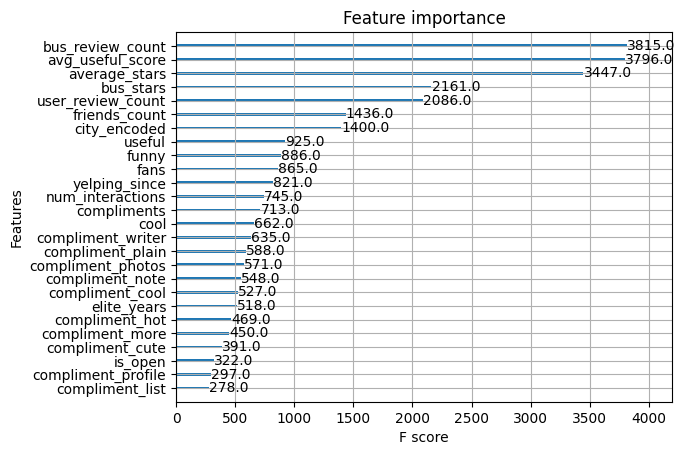

In [196]:
import xgboost as xgb
xgb.plot_importance(xgb_model)
plt.show()

In [198]:
eval_misclassification.head()

,bus_review_count,avg_useful_score,average_stars,bus_stars,user_review_count,friends_count,city_encoded,useful,funny,fans,yelping_since,num_interactions,compliments,cool,compliment_writer,compliment_plain,compliment_photos,compliment_note,compliment_cool,elite_years,user_id,business_id,prediction,stars,rounded_prediction
0,625,1.961538,4.42,4.0,42,32,416,21,2,1,15,23,2,0,0,0,1,0,0,0,zZu_XJiWi6lzls6O82HZqA,bSY97kgQpJ5BrpgW40V1qg,4.448787,2.0,4.0
1,49,0.750000,3.97,3.0,168,43,462,21,5,5,13,26,39,0,4,1,6,13,5,3,RNUV7k_Ng4KdasXQMsOo6w,74Q5s1J1xknMX7TAkIPf8w,3.436701,2.0,3.0
2,42,0.928571,3.29,3.0,260,275,984,20,11,25,13,46,296,15,41,45,9,44,63,7,EC5TGpxONfz4IZIjML0DpQ,q9kVbGaUwsalkhyFJdNQ0Q,2.860357,2.0,3.0
3,203,2.521739,3.68,3.0,159,97,984,31,28,10,13,74,134,15,20,19,1,25,20,7,DuzZ68TZWlQ3mALJZ0ASVQ,TrOgTZ0DfmQxvpTehiNibQ,3.250278,2.0,3.0
4,39,1.777778,3.59,2.5,1085,493,416,267,210,68,13,619,378,142,33,53,31,65,68,5,qPVtjjp8sNQ32p9860SR9Q,J2Am_nJkdicGk2S1DzwuPA,2.915234,2.0,3.0


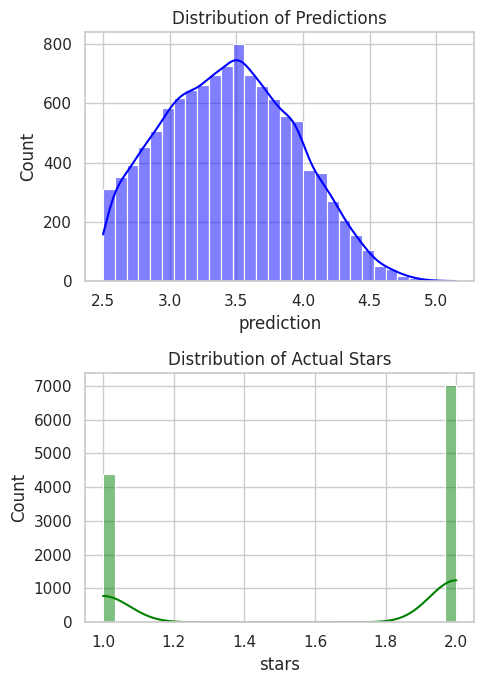

In [217]:
sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(eval_city_misclassified['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(eval_city_misclassified['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

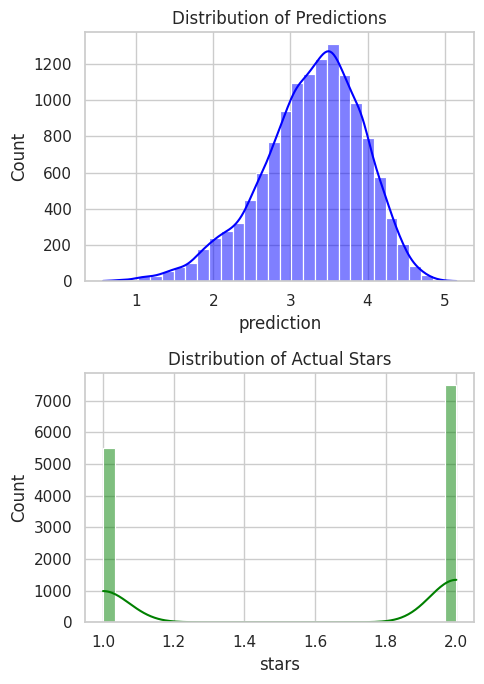

In [362]:
# specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data_stars_2_or_less = specific_city_data[specific_city_data['stars'] <= 2]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(specific_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(specific_city_data_stars_2_or_less['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

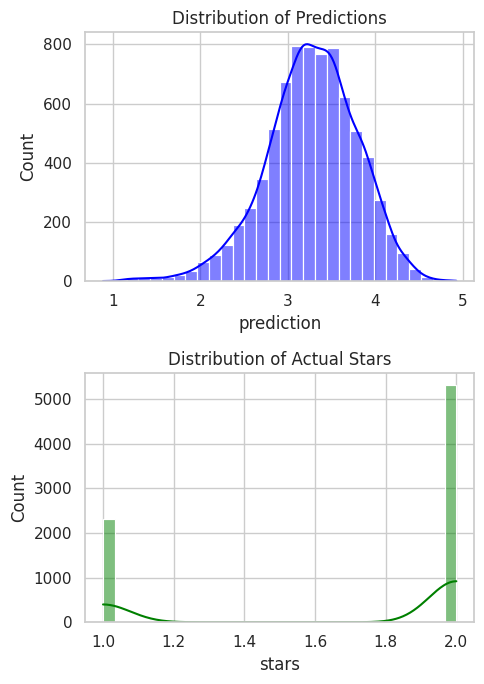

In [361]:
all_city_data_stars_2_or_less = combined_val_processed[combined_val_processed['stars'] <= 2]
all_city_data_stars_2_or_less = all_city_data_stars_2_or_less[~all_city_data_stars_2_or_less['city_encoded'].isin([416, 769, 155, 333, 725])]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(all_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[0], bins=30, color='blue')
axes[0].set_title('Distribution of Predictions')

sns.histplot(all_city_data_stars_2_or_less['stars'], kde=True, ax=axes[1], bins=30, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

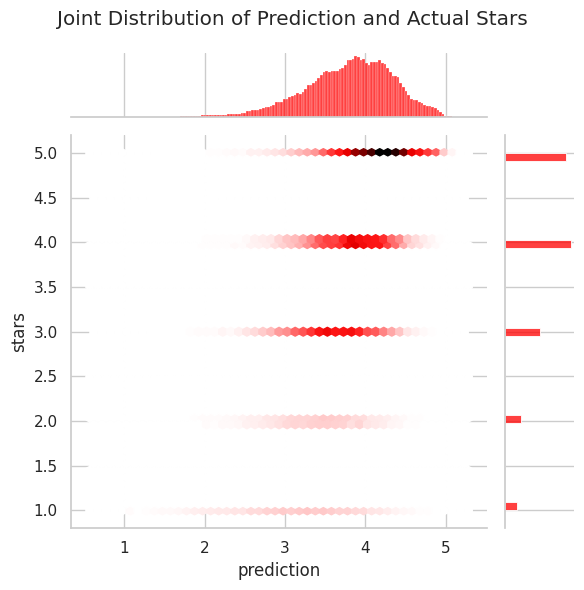

In [220]:
sns.jointplot(x='prediction', y='stars', data=specific_city_data, kind='hex', color='red')
plt.suptitle('Joint Distribution of Prediction and Actual Stars')
plt.tight_layout()
plt.show()

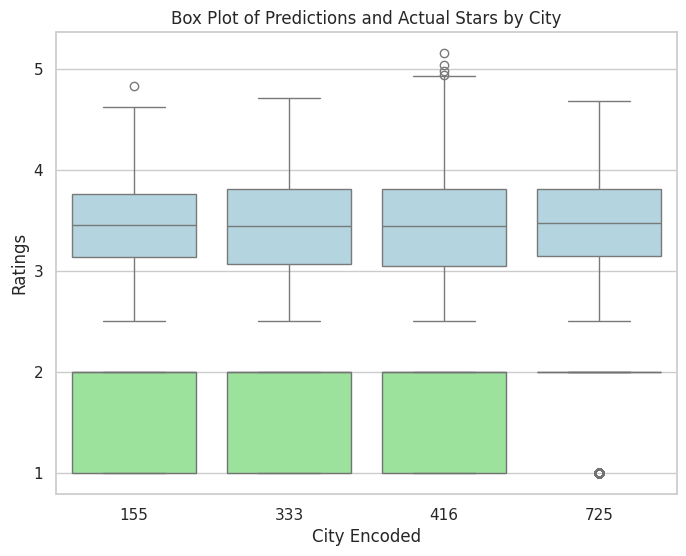

In [235]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=eval_city_misclassified, x='city_encoded', y='prediction', color='lightblue', ax=ax)
sns.boxplot(data=eval_city_misclassified, x='city_encoded', y='stars', color='lightgreen', ax=ax)
plt.title('Box Plot of Predictions and Actual Stars by City')
plt.xlabel('City Encoded')
plt.ylabel('Ratings')
plt.show()

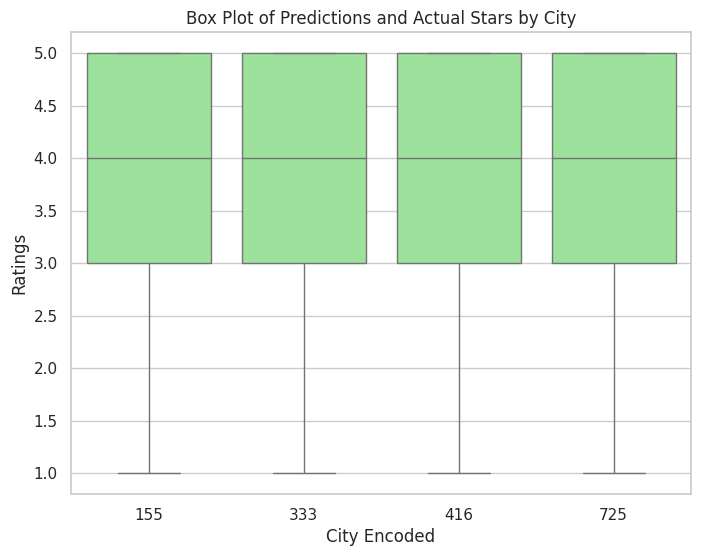

In [245]:
fig, ax = plt.subplots(figsize=(8, 6))
# sns.boxplot(data=specific_city_data, x='city_encoded', y='prediction', color='lightblue', ax=ax)
sns.boxplot(data=specific_city_data, x='city_encoded', y='stars', color='lightgreen', ax=ax)
plt.title('Box Plot of Predictions and Actual Stars by City')
plt.xlabel('City Encoded')
plt.ylabel('Ratings')
plt.show()

In [271]:
# fig, ax = plt.subplots(figsize=(80, 10))
# # sns.boxplot(data=specific_city_data, x='city_encoded', y='prediction', color='lightblue', ax=ax)
# sns.boxplot(data=combined_val_processed, x='city_encoded', y='stars', color='lightgreen', ax=ax)
# plt.title('Box Plot of Predictions and Actual Stars by City')
# plt.xlabel('City Encoded')
# plt.ylabel('Ratings')
# plt.show()

### Factors that cause overprediction of tail 1-2 score predictions: average_stars bus_stars bus_review_count avg_useful_score user_review_count

In [360]:
# bus_review_count	avg_useful_score	average_stars	bus_stars	user_review_count	friends_count	city_encoded	useful	funny	fans	yelping_since	num_interactions	compliments	cool	compliment_writer	
# compliment_plain	compliment_photos	compliment_note	compliment_cool	elite_years	user_id	business_id	prediction	stars	rounded_prediction

# average_stars overpredict
# bus_stars ovepredict
# bus_review_count overpredict
# avg_useful_score overpredict
# user_review_count

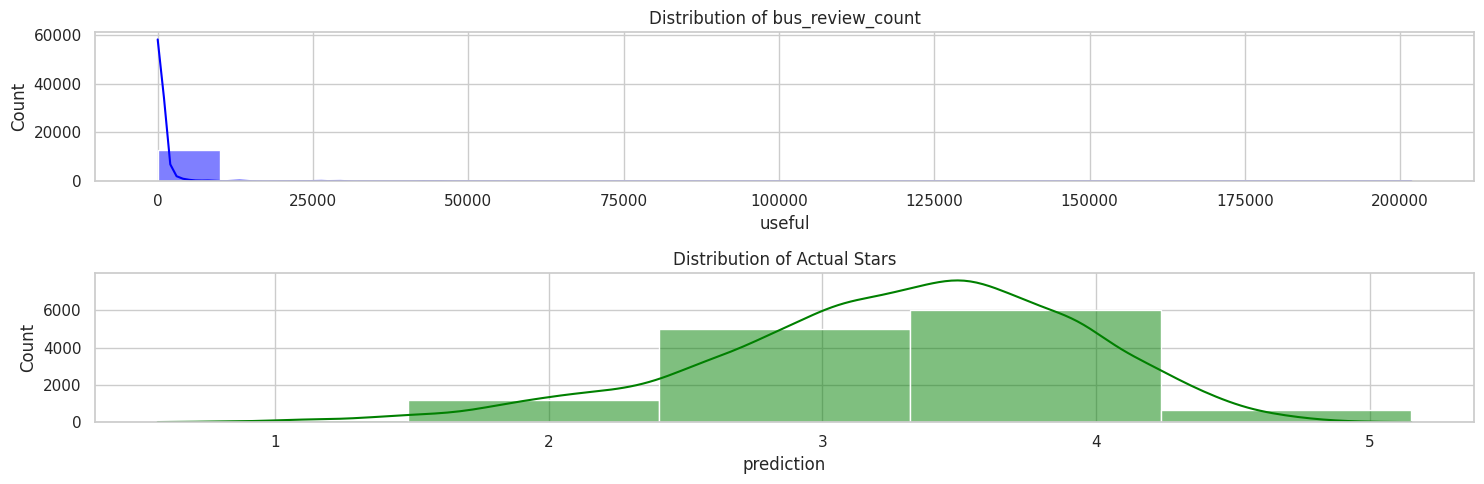

In [359]:
specific_city_data = combined_val_processed[(combined_val_processed['city_encoded'].isin([416, 769, 155, 333, 725]))]
specific_city_data_stars_2_or_less = specific_city_data[specific_city_data['stars'] <= 2]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(specific_city_data_stars_2_or_less['useful'], kde=True, ax=axes[0], bins=20, color='blue')
axes[0].set_title('Distribution of bus_review_count')

sns.histplot(specific_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[1], bins=5, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()

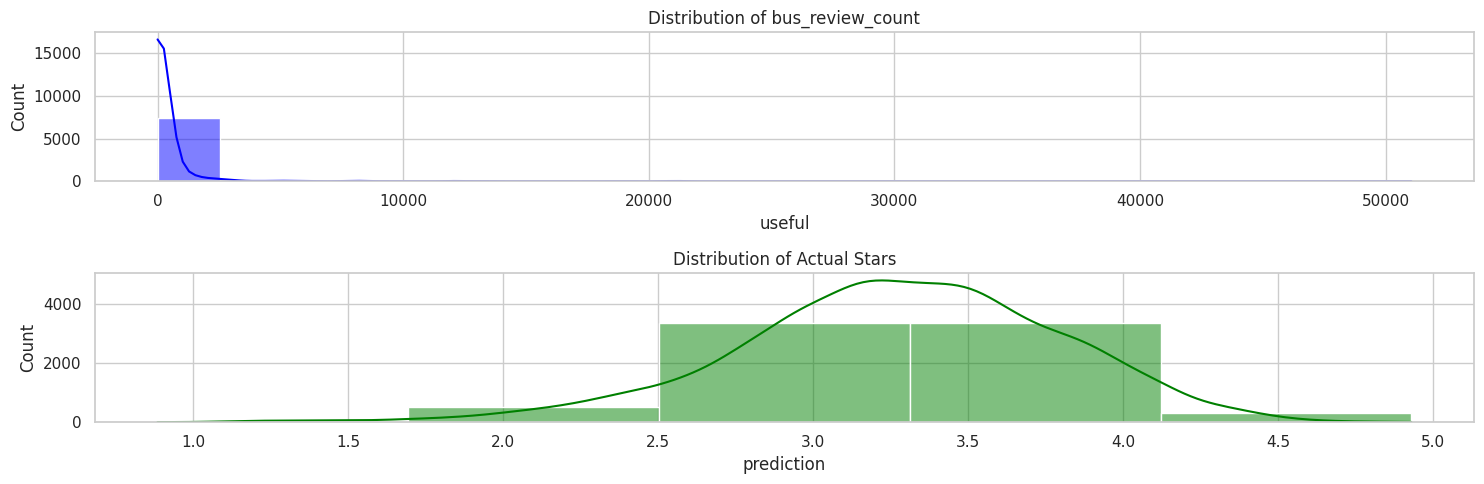

In [358]:
all_city_data_stars_2_or_less = combined_val_processed[combined_val_processed['stars'] <= 2]
all_city_data_stars_2_or_less = all_city_data_stars_2_or_less[~all_city_data_stars_2_or_less['city_encoded'].isin([416, 769, 155, 333, 725])]

sns.set(style="whitegrid")
# 创建一个图形框
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
# 在第一个轴上绘制预测评分的密度图
sns.histplot(all_city_data_stars_2_or_less['useful'], kde=True, ax=axes[0], bins=20, color='blue')
axes[0].set_title('Distribution of bus_review_count')

sns.histplot(all_city_data_stars_2_or_less['prediction'], kde=True, ax=axes[1], bins=5, color='green')
axes[1].set_title('Distribution of Actual Stars')
plt.tight_layout()
plt.show()